In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
%cd /content/drive/MyDrive/Github/Regression-Analysis/

/content/drive/MyDrive/Github/Regression-Analysis


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import matplotlib.pyplot as plt
import seaborn as sb
import statsmodels.api as sm
from sklearn.feature_selection import mutual_info_regression, f_regression, SelectKBest
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.neural_network import MLPRegressor

### Diamonds Dataset

In [ ]:
# Load the dataset
diamonds_data = pd.read_csv('/content/drive/MyDrive/Github/Regression-Analysis/diamonds.csv')
diamonds_data = diamonds_data.drop(diamonds_data.columns[[0]], axis = 1)
diamonds_data_original = diamonds_data.copy()
diamonds_data.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,330,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,327,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,328,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,337,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,338,4.34,4.35,2.75


In [ ]:
map_cut = {}
map_cut['Ideal'] = 4
map_cut['Premium'] = 3
map_cut['Very Good'] = 2
map_cut['Good'] = 1
map_cut['Fair'] = 0
diamonds_data['cut'] = diamonds_data['cut'].map(map_cut)

map_color = {}
map_color['D'] = 6 
map_color['E'] = 5
map_color['F'] = 4
map_color['G'] = 3
map_color['H'] = 2
map_color['I'] = 1
map_color['J'] = 0
diamonds_data['color'] = diamonds_data['color'].map(map_color)

map_clarity = {}
map_clarity['IF'] = 7 
map_clarity['VVS1'] = 6 
map_clarity['VVS2'] = 5
map_clarity['VS1'] = 4
map_clarity['VS2'] = 3
map_clarity['SI1'] = 2
map_clarity['SI2'] = 1
map_clarity['I1'] = 0
diamonds_data['clarity'] = diamonds_data['clarity'].map(map_clarity)

diamonds_data.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,4,5,1,61.5,55.0,330,3.95,3.98,2.43
1,0.21,3,5,2,59.8,61.0,327,3.89,3.84,2.31
2,0.23,1,5,4,56.9,65.0,328,4.05,4.07,2.31
3,0.29,3,1,3,62.4,58.0,337,4.20,4.23,2.63
4,0.31,1,0,1,63.3,58.0,338,4.34,4.35,2.75


**Question 1.1**

Plot a heatmap of the Pearson correlation matrix of the dataset columns. Report
which features have the highest absolute correlation with the target variable. In the context of either dataset, describe what the correlation patterns suggest.

**Ans** 


---


In the context of either dataset, describe what the correlation patterns suggest.

In [ ]:
corr = diamonds_data.corr(method='pearson')
corr.style.background_gradient(cmap='coolwarm')

,carat,cut,color,clarity,depth,table,price,x,y,z
carat,1.000000,-0.134967,-0.291437,-0.352841,0.028224,0.181618,0.921591,0.975094,0.951722,0.953387
cut,-0.134967,1.000000,0.020519,0.189175,-0.218055,-0.433405,-0.053493,-0.125565,-0.121462,-0.149323
color,-0.291437,0.020519,1.000000,-0.025631,-0.047279,-0.026465,-0.172509,-0.270287,-0.263584,-0.268227
clarity,-0.352841,0.189175,-0.025631,1.000000,-0.067384,-0.160327,-0.146802,-0.371999,-0.358420,-0.366952
depth,0.028224,-0.218055,-0.047279,-0.067384,1.000000,-0.295779,-0.010648,-0.025289,-0.029341,0.094924
table,0.181618,-0.433405,-0.026465,-0.160327,-0.295779,1.000000,0.127134,0.195344,0.183760,0.150929
price,0.921591,-0.053493,-0.172509,-0.146802,-0.010648,0.127134,1.000000,0.884436,0.865422,0.861250
x,0.975094,-0.125565,-0.270287,-0.371999,-0.025289,0.195344,0.884436,1.000000,0.974701,0.970772
y,0.951722,-0.121462,-0.263584,-0.358420,-0.029341,0.183760,0.865422,0.974701,1.000000,0.952006
z,0.953387,-0.149323,-0.268227,-0.366952,0.094924,0.150929,0.861250,0.970772,0.952006,1.000000


In [ ]:
# Variables that are highly correlated with (target variable) price using absolute correlation
hc_var = abs(diamonds_data.corr()).sort_values('price', ascending=False).index
hc_var = list(hc_var)

print("""The variables that are correlated with price \n (in order of absolute pearson coefficient) are: \n""", hc_var[1:])

The variables that are correlated with price 
 (in order of absolute pearson coefficient) are: 
 ['carat', 'x', 'y', 'z', 'color', 'clarity', 'table', 'cut', 'depth']


**Question 1.2**

Plot the histogram of numerical features. What preprocessing can be done if the
distribution of a feature has high skewness? 

**Ans** 


---



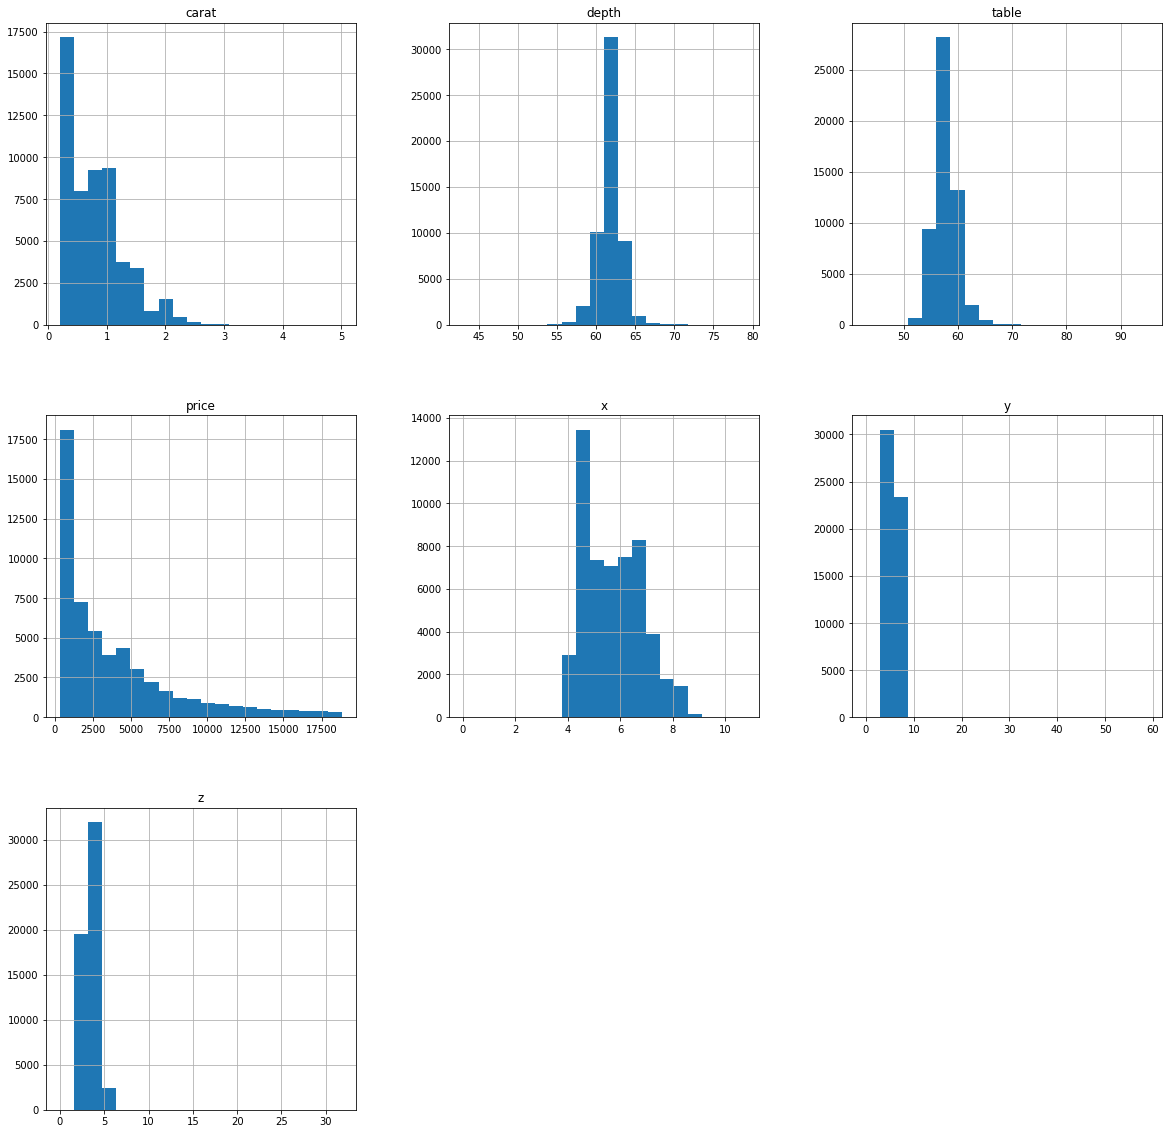

In [ ]:
axarr = diamonds_data_original.hist(bins=20, figsize=(20,20))

**Question 1.3**

Construct and inspect the box plot of categorical features vs target variable. What do you find?

**Ans** 


---



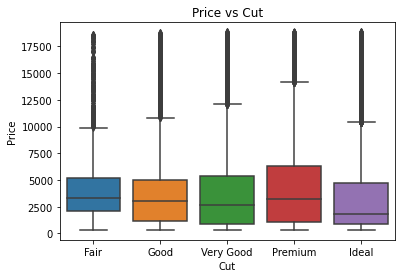

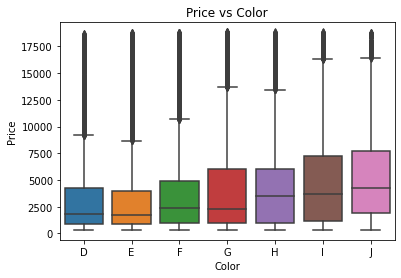

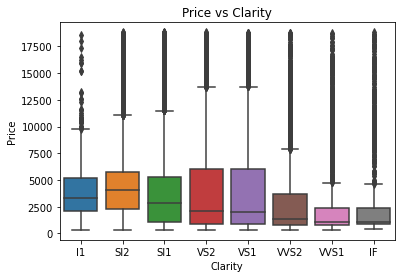

In [ ]:
ax = sb.boxplot(x = 'cut', y = 'price', data = diamonds_data_original, order = ['Fair', 'Good', 'Very Good', 'Premium', 'Ideal'])
ax.set_xlabel('Cut')
ax.set_ylabel('Price')
ax.set_title('Price vs Cut')
plt.show()

ax = sb.boxplot(x = 'color', y = 'price', data = diamonds_data_original, order=['D', 'E', 'F', 'G', 'H', 'I', 'J'])
ax.set_xlabel('Color')
ax.set_ylabel('Price')
ax.set_title('Price vs Color')
plt.show()

ax = sb.boxplot(x = 'clarity', y = 'price', data = diamonds_data_original, order = ['I1', 'SI2', 'SI1', 'VS2','VS1','VVS2','VVS1','IF'])
ax.set_xlabel('Clarity')
ax.set_ylabel('Price')
ax.set_title('Price vs Clarity')
plt.show()

**Question 1.4**

For the Diamonds dataset, plot the counts by color, cut and clarity

**Ans** 


---



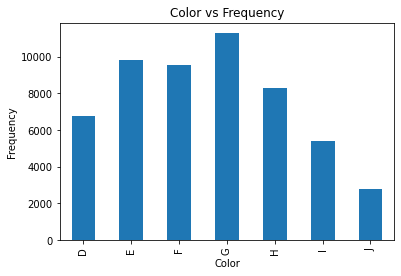

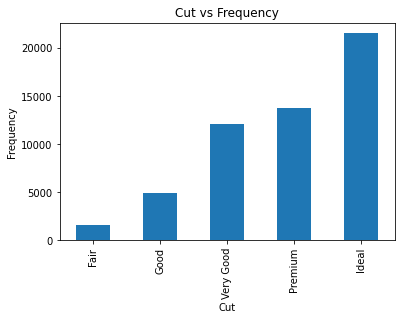

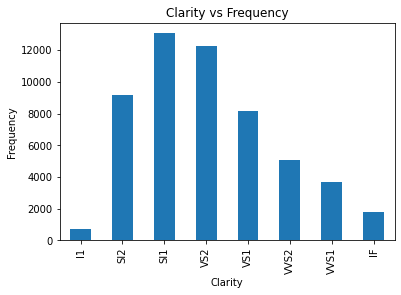

In [ ]:
order = ['D','E','F','G','H','I','J']
ax = diamonds_data_original['color'].value_counts().loc[order].plot.bar()
ax.set_xlabel('Color')
ax.set_ylabel('Frequency')
ax.set_title('Color vs Frequency')
plt.show()

order = ['Fair','Good','Very Good','Premium','Ideal']
ax = diamonds_data_original['cut'].value_counts().loc[order].plot.bar()
ax.set_xlabel('Cut')
ax.set_ylabel('Frequency')
ax.set_title('Cut vs Frequency')
plt.show()

order = ['I1','SI2','SI1','VS2','VS1','VVS2','VVS1','IF']
ax = diamonds_data_original['clarity'].value_counts().loc[order].plot.bar()
ax.set_xlabel('Clarity')
ax.set_ylabel('Frequency')
ax.set_title('Clarity vs Frequency')
plt.show()

**Question 2.1**

Standardize feature columns and prepare them for training.

In [ ]:
def standardize_data(X_train, X_test, y_train, y_test):

    # Standardize the feature columns
    scaler = StandardScaler()
    cols = list(set(X_train.columns).intersection(['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'x', 'y', 'z']))
    X_train[cols] = scaler.fit_transform(X_train[cols])
    X_test[cols] = scaler.transform(X_test[cols])

    return X_train, X_test, y_train, y_test

In [ ]:
# Only to show how standardization is done
X = diamonds_data.drop(columns='price')
y = diamonds_data['price']
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_std, X_test_std, y_train_std, y_test_std = standardize_data(X_train, X_test, y_train, y_test)
X_train_std.head()

,carat,cut,color,clarity,depth,table,x,y,z
26546,2.560056,-1.708965,0.347949,-1.246901,-2.550748,2.933861,2.229450,2.138209,1.738207
9159,0.447392,-0.812192,0.936621,-1.246901,-1.220426,1.139575,0.747550,0.656710,0.537733
14131,0.637532,0.084582,-0.829396,-0.032134,0.529996,0.242432,0.765404,0.700284,0.791951
15757,1.482597,-1.708965,0.936621,-1.246901,-0.170173,3.382432,1.318885,1.249310,1.243894
24632,1.524851,-0.812192,-0.240724,0.575249,0.249928,-0.206140,1.372448,1.380030,1.399249


**Question 2.2**

**sklearn.feature selection.mutual** info regression function returns estimated mutual information between each feature and the label. Mutual information (MI)
between two random variables is a non-negative value which measures the dependency between the variables. It is equal to zero if and only if two random variables are independent, and higher values mean higher dependency.

**sklearn.feature selection.f** regression function provides F scores, which is a way of comparing the significance of the improvement of a model, with respect to the addition of new variables.

You **may** use these functions to select features that yield better regression results (especially in the classical models). Describe how this step qualitatively affects the performance of your models in terms of test RMSE. Is it true for all model types? Also list two features for either dataset that has the lowest MI w.r.t to the target. 

In [ ]:
# MIR: Mutual info regression; FR: f-regression
# Linear Regression without regularization
RMSE_MIR = []
RMSE_FR = []

# Ridge Regression
RMSE_MIR_RR = []
RMSE_FR_RR = []

# Lasso regression
RMSE_MIR_LR = []
RMSE_FR_LR = []

for i in range(1, X.shape[1]+1):
    print('\nk: ', i)
    X_MIR = SelectKBest(score_func=mutual_info_regression, k=i).fit_transform(X, y)
    X_FR = SelectKBest(score_func=f_regression, k=i).fit_transform(X, y)
    # Get the selected feature names
    feature_names = diamonds_data.columns[:-1]  # exclude target column
    selected_MIR = feature_names[SelectKBest(score_func=mutual_info_regression, k=i).fit(X, y).get_support()]
    selected_FR = feature_names[SelectKBest(score_func=f_regression, k=i).fit(X, y).get_support()]

    print(f"Selected MIR features: {selected_MIR}")
    print(f"Selected FR features: {selected_FR}")
    
    print('Testing Linear Regression...')
    output = cross_validate(LinearRegression(), X_MIR, y, scoring=['neg_root_mean_squared_error'], cv=10, n_jobs=-1)
    RMSE_MIR.append(output['test_neg_root_mean_squared_error'].mean())
    output = cross_validate(LinearRegression(), X_FR, y, scoring=['neg_root_mean_squared_error'], cv=10, n_jobs=-1)
    RMSE_FR.append(output['test_neg_root_mean_squared_error'].mean())
    
    print('Testing Ridge Regression...')
    output = cross_validate(Ridge(), X_MIR, y, scoring=['neg_root_mean_squared_error'], cv=10, n_jobs=-1)
    RMSE_MIR_RR.append(output['test_neg_root_mean_squared_error'].mean())
    output = cross_validate(Ridge(), X_FR, y, scoring=['neg_root_mean_squared_error'], cv=10, n_jobs=-1)
    RMSE_FR_RR.append(output['test_neg_root_mean_squared_error'].mean())
    
    print('Testing Lasso Regression...')
    output = cross_validate(Lasso(), X_MIR, y, scoring=['neg_root_mean_squared_error'], cv=10, n_jobs=-1)
    RMSE_MIR_LR.append(output['test_neg_root_mean_squared_error'].mean())
    output = cross_validate(Lasso(), X_FR, y, scoring=['neg_root_mean_squared_error'], cv=10, n_jobs=-1)
    RMSE_FR_LR.append(output['test_neg_root_mean_squared_error'].mean())
    print('-'*25)



k:  1
Selected MIR features: Index(['carat'], dtype='object')
Selected FR features: Index(['carat'], dtype='object')
Testing Linear Regression...
Testing Ridge Regression...
Testing Lasso Regression...
-------------------------

k:  2
Selected MIR features: Index(['carat', 'x'], dtype='object')
Selected FR features: Index(['carat', 'price'], dtype='object')
Testing Linear Regression...
Testing Ridge Regression...
Testing Lasso Regression...
-------------------------

k:  3
Selected MIR features: Index(['carat', 'price', 'x'], dtype='object')
Selected FR features: Index(['carat', 'price', 'x'], dtype='object')
Testing Linear Regression...
Testing Ridge Regression...
Testing Lasso Regression...
-------------------------

k:  4
Selected MIR features: Index(['carat', 'price', 'x', 'y'], dtype='object')
Selected FR features: Index(['carat', 'price', 'x', 'y'], dtype='object')
Testing Linear Regression...
Testing Ridge Regression...
Testing Lasso Regression...
-------------------------

k: 

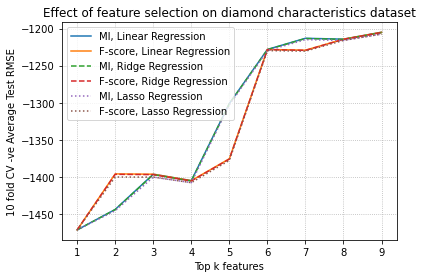

In [ ]:
plt.plot(np.arange(1,len(RMSE_MIR)+1,1),    RMSE_MIR,         label = 'MI, Linear Regression')
plt.plot(np.arange(1,len(RMSE_FR)+1,1),     RMSE_FR,          label = 'F-score, Linear Regression')
plt.plot(np.arange(1,len(RMSE_MIR_RR)+1,1), RMSE_MIR_RR,'--', label = 'MI, Ridge Regression')
plt.plot(np.arange(1,len(RMSE_FR_RR)+1,1),  RMSE_FR_RR,'--',  label = 'F-score, Ridge Regression')
plt.plot(np.arange(1,len(RMSE_MIR_LR)+1,1), RMSE_MIR_LR,':',  label = 'MI, Lasso Regression')
plt.plot(np.arange(1,len(RMSE_FR_LR)+1,1),  RMSE_FR_LR,':',   label = 'F-score, Lasso Regression')
plt.legend(loc='best')
plt.grid(linestyle=':')
plt.xlabel('Top k features')
plt.ylabel('10 fold CV -ve Average Test RMSE')
plt.title('Effect of feature selection on diamond characteristics dataset')
plt.show()

In [ ]:
# Define the number of features to select
k_val = 6

# Select the top k features using F-regression and mutual information regression
selector_FR = SelectKBest(score_func=f_regression, k=k_val)
selector_MIR = SelectKBest(score_func=mutual_info_regression, k=k_val)

Perform 10-fold cross-validation and measure average RMSE errors for training and validation sets.

**Section 3.3.1** Linear Lasso Ridge Regression

In [ ]:
# create a custom transformer for scaling the data within each fold separately
class FoldStandardScaler(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.scaler_train = StandardScaler()
        self.scaler_test = StandardScaler()

    def fit(self, X, y=None):
        X_train = X[:, :-1]
        X_val = X[:, -1:]
        self.scaler_train.fit_transform(X_train)
        self.scaler_test.fit(X_val)
        return self

    def transform(self, X, y=None):
        X_train = X[:, :-1]
        X_val = X[:, -1:]
        X_train = self.scaler_train.transform(X_train)
        X_val = self.scaler_test.transform(X_val)
        return np.hstack([X_train, X_val])


In [ ]:
# Define the models to train with pipeline
models = [Pipeline([
               ('scaler', FoldStandardScaler()),
               ('linear_reg_FR', LinearRegression())
           ]), 
          Pipeline([
               ('scaler', FoldStandardScaler()),
               ('linear_reg_MIR', LinearRegression())
           ])]

# Train each model and evaluate its performance
for i, model in enumerate(models):
    # Fit the model with selected features and evaluate its performance
    if i == 0:
        X_selected = selector_FR.fit_transform(X, y)
        cols = X.columns[selector_FR.get_support()]
        scores = cross_validate(model, X_selected, y, cv=10, scoring='neg_root_mean_squared_error', return_train_score=True)
        print('Linear Regression with FoldStandardScaler and F-regression feature selection:')
    elif i == 1:
        X_selected = selector_MIR.fit_transform(X, y)
        cols = X.columns[selector_MIR.get_support()]
        scores = cross_validate(model, X_selected, y, cv=10, scoring='neg_root_mean_squared_error', return_train_score=True)
        print('Linear Regression with FoldStandardScaler and mutual information regression feature selection:')
    
    # Print the average scores for training and validation sets
    print('Training set RMSE:', scores['train_score'].mean())
    print('Validation set RMSE:', scores['test_score'].mean())
    print()


Linear Regression with FoldStandardScaler and F-regression feature selection:
Training set RMSE: -1221.6042206336504
Validation set RMSE: -1228.2203041711432

Linear Regression with FoldStandardScaler and mutual information regression feature selection:
Training set RMSE: -1221.6042206336504
Validation set RMSE: -1228.2203041711432



In [ ]:
# Define the models to train with pipeline
models = [Pipeline([               ('scale', FoldStandardScaler()),               ('lasso_FR', Lasso())           ]), 
          Pipeline([               ('scale', FoldStandardScaler()),               ('lasso_MIR', Lasso())           ]), 
          Pipeline([               ('scale', FoldStandardScaler()),               ('ridge_FR', Ridge())           ]), 
          Pipeline([               ('scale', FoldStandardScaler()),               ('ridge_MIR', Ridge())           ])]

# Define the hyperparameters for grid search
params = [{'lasso_FR__alpha': [10.0**x for x in np.arange(-5,5)]},
          {'lasso_MIR__alpha': [10.0**x for x in np.arange(-5,5)]},
          {'ridge_FR__alpha': [10.0**x for x in np.arange(-5,5)]},
          {'ridge_MIR__alpha': [10.0**x for x in np.arange(-5,5)]}]

# Train each model with grid search and evaluate its performance
for i, model in enumerate(models):
    if i in [0,2]: # feature selection using FR
        X_selected = selector_FR.fit_transform(X, y)
    else: # feature selection using MIR
        X_selected = selector_MIR.fit_transform(X, y)
    grid = GridSearchCV(model, params[i], scoring='neg_root_mean_squared_error', cv=10, n_jobs=1, return_train_score=True)
    grid.fit(X_selected, y)
    
    # Print the best hyperparameters and the corresponding scores for training and validation sets
    print('Model {}:'.format(i))
    print('Best hyperparameters:', grid.best_params_)
    print('Training set RMSE:', grid.cv_results_['mean_train_score'][grid.best_index_])
    print('Validation set RMSE:', grid.cv_results_['mean_test_score'][grid.best_index_])
    print()
    

Model 0:
Best hyperparameters: {'lasso_FR__alpha': 1e-05}
Training set RMSE: -1221.6042206336576
Validation set RMSE: -1228.2203123582412

Model 1:
Best hyperparameters: {'lasso_MIR__alpha': 1e-05}
Training set RMSE: -1221.6042206336576
Validation set RMSE: -1228.2203123582412

Model 2:
Best hyperparameters: {'ridge_FR__alpha': 1e-05}
Training set RMSE: -1221.6042206336504
Validation set RMSE: -1228.2203047136793

Model 3:
Best hyperparameters: {'ridge_MIR__alpha': 1e-05}
Training set RMSE: -1221.6042206336504
Validation set RMSE: -1228.2203047136793



In [ ]:
# Ridge and Lasso Regression without standardization

# Define the models to train with pipeline
models = [Pipeline([
               ('lasso_FR', Lasso())
           ]), 
          Pipeline([
               ('lasso_MIR', Lasso())
           ]), 
          Pipeline([
               ('ridge_FR', Ridge())
           ]), 
          Pipeline([
               ('ridge_MIR', Ridge())
           ])]

# Define the hyperparameters for grid search
params = [{'lasso_FR__alpha': [10.0**x for x in np.arange(-5,5)]},
          {'lasso_MIR__alpha': [10.0**x for x in np.arange(-5,5)]},
          {'ridge_FR__alpha': [10.0**x for x in np.arange(-5,5)]},
          {'ridge_MIR__alpha': [10.0**x for x in np.arange(-5,5)]}]

# Train each model with grid search and evaluate its performance
for i, model in enumerate(models):
    # Perform grid search with 10-fold cross-validation and measure average RMSE errors for training and validation sets
    if i == 0:
        X_selected = selector_FR.fit_transform(X, y)
        grid = GridSearchCV(model, params[i], scoring='neg_root_mean_squared_error', cv=10, n_jobs=-1, return_train_score=True)
        grid.fit(X_selected, y)
        print('{} without standardization and F-regression feature selection:'.format(type(model.steps[-1][-1]).__name__))
    elif i == 1:
        X_selected = selector_MIR.fit_transform(X, y)
        grid = GridSearchCV(model, params[i], scoring='neg_root_mean_squared_error', cv=10, n_jobs=-1, return_train_score=True)
        grid.fit(X_selected, y)
        print('{} without standardization and mutual information regression feature selection:'.format(type(model.steps[-1][-1]).__name__))
    elif i == 2:
        X_selected = selector_FR.fit_transform(X, y)
        grid = GridSearchCV(model, params[i], scoring='neg_root_mean_squared_error', cv=10, n_jobs=-1, return_train_score=True)
        grid.fit(X_selected, y)
        print('{} without standardization and F-regression feature selection:'.format(type(model.steps[-1][-1]).__name__))
    elif i == 3:
        X_selected = selector_MIR.fit_transform(X, y)
        grid = GridSearchCV(model, params[i], scoring='neg_root_mean_squared_error', cv=10, n_jobs=-1, return_train_score=True)
        grid.fit(X_selected, y)
        print('{} without standardization and mutual information regression feature selection:'.format(type(model.steps[-1][-1]).__name__))
    
    # Print the best hyperparameters and the corresponding scores for training and validation sets
    print('Best hyperparameters:', grid.best_params_)
    print('Training set RMSE:', grid.cv_results_['mean_train_score'][grid.best_index_])
    print('Validation set RMSE:', grid.cv_results_['mean_test_score'][grid.best_index_])
    print()


Lasso without standardization and F-regression feature selection:
Best hyperparameters: {'lasso_FR__alpha': 1e-05}
Training set RMSE: -1221.6042206336629
Validation set RMSE: -1228.2203178503926

Lasso without standardization and mutual information regression feature selection:
Best hyperparameters: {'lasso_MIR__alpha': 1e-05}
Training set RMSE: -1221.6042206336629
Validation set RMSE: -1228.2203178503926

Ridge without standardization and F-regression feature selection:
Best hyperparameters: {'ridge_FR__alpha': 1e-05}
Training set RMSE: -1221.6042206336504
Validation set RMSE: -1228.2203070191495

Ridge without standardization and mutual information regression feature selection:
Best hyperparameters: {'ridge_MIR__alpha': 1e-05}
Training set RMSE: -1221.6042206336504
Validation set RMSE: -1228.2203070191495



In [ ]:
# Fit a linear regression model
model = sm.OLS(y, sm.add_constant(X)).fit()

# Print the p-values for the coefficients
print(model.pvalues.sort_values(ascending=True))

carat       0.000000e+00
color       0.000000e+00
clarity     0.000000e+00
x          3.098309e-136
cut         1.113990e-98
depth       4.663890e-62
table       1.130952e-19
const       1.870600e-18
y           3.501855e-02
z           4.158692e-01
dtype: float64


**Section 3.3.2** Polynomial Regression

In [ ]:
# create a pipeline with PolynomialFeatures, FoldStandardScaler and Ridge Regression
pipe_PR = Pipeline([
    ('PR', PolynomialFeatures()),
    ('scale', FoldStandardScaler()),
    ('model', Ridge(random_state=21))
])

degree_l = np.array([1,2,3,4,5])

param_grid_PR = {
    'PR__degree': degree_l,
    'model__alpha': [10.0**x for x in np.array([-5,-3,0,3,5])]
}

grid_PR = GridSearchCV(pipe_PR, param_grid=param_grid_PR, cv=10, n_jobs=1, verbose=10, 
                     scoring='neg_root_mean_squared_error', 
                     return_train_score=True).fit(X, y)


Fitting 10 folds for each of 25 candidates, totalling 250 fits
[CV 1/10; 1/25] START PR__degree=1, model__alpha=1e-05..........................
[CV 1/10; 1/25] END PR__degree=1, model__alpha=1e-05;, score=(train=-1246.677, test=-942.742) total time=   0.0s
[CV 2/10; 1/25] START PR__degree=1, model__alpha=1e-05..........................
[CV 2/10; 1/25] END PR__degree=1, model__alpha=1e-05;, score=(train=-1248.662, test=-918.481) total time=   0.1s
[CV 3/10; 1/25] START PR__degree=1, model__alpha=1e-05..........................
[CV 3/10; 1/25] END PR__degree=1, model__alpha=1e-05;, score=(train=-1230.784, test=-1112.581) total time=   0.1s
[CV 4/10; 1/25] START PR__degree=1, model__alpha=1e-05..........................
[CV 4/10; 1/25] END PR__degree=1, model__alpha=1e-05;, score=(train=-1190.651, test=-1480.568) total time=   0.1s
[CV 5/10; 1/25] START PR__degree=1, model__alpha=1e-05..........................
[CV 5/10; 1/25] END PR__degree=1, model__alpha=1e-05;, score=(train=-954.234, 

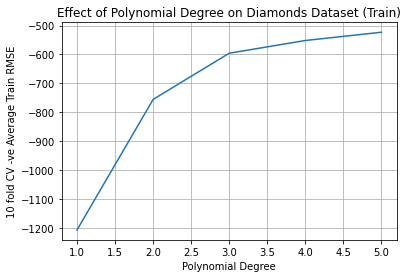

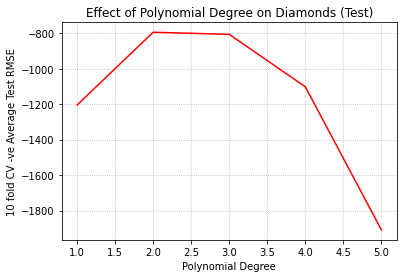

In [ ]:
dia_train_score = []
dia_test_score = []
dia_alpha = []

poly_res = pd.DataFrame(grid_PR.cv_results_)[['mean_test_score','mean_train_score','param_PR__degree','param_model__alpha']]

for i in degree_l:
    dia_test_score.append((poly_res.loc[poly_res['param_PR__degree'] == i]).max().mean_test_score)
    dia_train_score.append((poly_res.loc[poly_res['param_PR__degree'] == i]).max().mean_train_score)
    dia_alpha.append(float(poly_res['param_model__alpha'][(poly_res.loc[poly_res['param_PR__degree'] == i])[['mean_test_score']].idxmax()].to_numpy()))
    
plt.plot(degree_l,dia_train_score)
plt.grid(linestyle='-')
plt.xlabel('Polynomial Degree')
plt.ylabel('10 fold CV -ve Average Train RMSE')
plt.title('Effect of Polynomial Degree on Diamonds Dataset (Train)')
plt.show()

plt.plot(degree_l,dia_test_score,'r')
plt.grid(linestyle=':')
plt.xlabel('Polynomial Degree')
plt.ylabel('10 fold CV -ve Average Test RMSE')
plt.title('Effect of Polynomial Degree on Diamonds (Test)')
plt.show()

In [ ]:
poly_result = pd.DataFrame(grid_PR.cv_results_)[['mean_test_score','mean_train_score',
                                                 'param_PR__degree','param_model__alpha']]
print('Best parameters (diamond dataset): {} \n Train RMSE: {} \nTest RMSE: {}'.format(grid_PR.best_params_,
                                                                                       max(poly_result.mean_train_score),
                                                                                       grid_PR.best_score_))

Best parameters (diamond dataset): {'PR__degree': 2, 'model__alpha': 1000.0} 
 Train RMSE: -523.151557853977 
Test RMSE: -794.164314834404


In [ ]:
k_opt = X.shape[1]

skbest = SelectKBest(score_func=f_regression, k=k_opt)
skbest_fit = skbest.fit_transform(X_train, y_train)

column_names = X.columns[skbest.get_support()]
b_params = grid_PR.best_estimator_.get_params()
b_coefs = b_params['model'].coef_
b_feature_name = list(column_names)
b_names = b_params['PR'].get_feature_names_out(b_feature_name)

b_sorted_indice = np.argsort(-abs(b_coefs))
salient_features =[b_names[i] for i in b_sorted_indice[:k_opt]]
print ('Top Salient features in order (in order from top to lower):', salient_features)

Top Salient features in order (in order from top to lower): ['carat clarity', 'carat color', 'carat y', 'carat x', 'carat z', 'color clarity', 'carat cut', 'depth x', 'x']


**Section 3.3.3** Neural Network

In [ ]:
# create a pipeline with feature selection and scaling
pipe_FR = Pipeline([
    ('selector', SelectKBest(score_func=f_regression, k=k_val)),
    ('scaler', FoldStandardScaler()),
])

# define the parameter grid for the neural network
nn_combinations = [[32], [64], [8,16,32,64]]
param_grid_NN = {
    'model__hidden_layer_sizes': nn_combinations,
    'model__alpha': [10.0**x for x in np.array([-3,0])],
    'model__activation': ['relu', 'tanh', 'logistic']   
}

# create a pipeline for the neural network with feature selection and scaling
pipe_NN = Pipeline([
    ('preprocessor', pipe_FR),
    ('model', MLPRegressor(random_state=21, max_iter=200))
])

# perform grid search with cross-validation
grid_NN = GridSearchCV(pipe_NN, param_grid=param_grid_NN, cv=10, n_jobs=1, verbose=10,
                       scoring='neg_root_mean_squared_error', return_train_score=True)
grid_NN.fit(X, y)


Fitting 10 folds for each of 18 candidates, totalling 180 fits
[CV 1/10; 1/18] START model__activation=relu, model__alpha=0.001, model__hidden_layer_sizes=[32]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/10; 1/18] END model__activation=relu, model__alpha=0.001, model__hidden_layer_sizes=[32];, score=(train=-908.972, test=-721.022) total time=  22.3s
[CV 2/10; 1/18] START model__activation=relu, model__alpha=0.001, model__hidden_layer_sizes=[32]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/10; 1/18] END model__activation=relu, model__alpha=0.001, model__hidden_layer_sizes=[32];, score=(train=-895.811, test=-697.397) total time=  24.2s
[CV 3/10; 1/18] START model__activation=relu, model__alpha=0.001, model__hidden_layer_sizes=[32]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/10; 1/18] END model__activation=relu, model__alpha=0.001, model__hidden_layer_sizes=[32];, score=(train=-883.005, test=-929.342) total time=  23.3s
[CV 4/10; 1/18] START model__activation=relu, model__alpha=0.001, model__hidden_layer_sizes=[32]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/10; 1/18] END model__activation=relu, model__alpha=0.001, model__hidden_layer_sizes=[32];, score=(train=-826.886, test=-1221.514) total time=  23.4s
[CV 5/10; 1/18] START model__activation=relu, model__alpha=0.001, model__hidden_layer_sizes=[32]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/10; 1/18] END model__activation=relu, model__alpha=0.001, model__hidden_layer_sizes=[32];, score=(train=-706.099, test=-1910.115) total time=  23.9s
[CV 6/10; 1/18] START model__activation=relu, model__alpha=0.001, model__hidden_layer_sizes=[32]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 6/10; 1/18] END model__activation=relu, model__alpha=0.001, model__hidden_layer_sizes=[32];, score=(train=-820.446, test=-1330.724) total time=  22.3s
[CV 7/10; 1/18] START model__activation=relu, model__alpha=0.001, model__hidden_layer_sizes=[32]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 7/10; 1/18] END model__activation=relu, model__alpha=0.001, model__hidden_layer_sizes=[32];, score=(train=-1410.385, test=-201.038) total time=  24.2s
[CV 8/10; 1/18] START model__activation=relu, model__alpha=0.001, model__hidden_layer_sizes=[32]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 8/10; 1/18] END model__activation=relu, model__alpha=0.001, model__hidden_layer_sizes=[32];, score=(train=-921.105, test=-317.661) total time=  22.4s
[CV 9/10; 1/18] START model__activation=relu, model__alpha=0.001, model__hidden_layer_sizes=[32]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 9/10; 1/18] END model__activation=relu, model__alpha=0.001, model__hidden_layer_sizes=[32];, score=(train=-904.758, test=-884.051) total time=  24.3s
[CV 10/10; 1/18] START model__activation=relu, model__alpha=0.001, model__hidden_layer_sizes=[32]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 10/10; 1/18] END model__activation=relu, model__alpha=0.001, model__hidden_layer_sizes=[32];, score=(train=-918.529, test=-741.716) total time=  23.4s
[CV 1/10; 2/18] START model__activation=relu, model__alpha=0.001, model__hidden_layer_sizes=[64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/10; 2/18] END model__activation=relu, model__alpha=0.001, model__hidden_layer_sizes=[64];, score=(train=-842.951, test=-621.928) total time=  50.0s
[CV 2/10; 2/18] START model__activation=relu, model__alpha=0.001, model__hidden_layer_sizes=[64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/10; 2/18] END model__activation=relu, model__alpha=0.001, model__hidden_layer_sizes=[64];, score=(train=-831.098, test=-654.256) total time=  49.3s
[CV 3/10; 2/18] START model__activation=relu, model__alpha=0.001, model__hidden_layer_sizes=[64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/10; 2/18] END model__activation=relu, model__alpha=0.001, model__hidden_layer_sizes=[64];, score=(train=-816.776, test=-878.531) total time=  49.2s
[CV 4/10; 2/18] START model__activation=relu, model__alpha=0.001, model__hidden_layer_sizes=[64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/10; 2/18] END model__activation=relu, model__alpha=0.001, model__hidden_layer_sizes=[64];, score=(train=-753.522, test=-1192.806) total time=  52.4s
[CV 5/10; 2/18] START model__activation=relu, model__alpha=0.001, model__hidden_layer_sizes=[64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/10; 2/18] END model__activation=relu, model__alpha=0.001, model__hidden_layer_sizes=[64];, score=(train=-651.495, test=-1727.546) total time=  49.7s
[CV 6/10; 2/18] START model__activation=relu, model__alpha=0.001, model__hidden_layer_sizes=[64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 6/10; 2/18] END model__activation=relu, model__alpha=0.001, model__hidden_layer_sizes=[64];, score=(train=-747.527, test=-1215.866) total time=  49.1s
[CV 7/10; 2/18] START model__activation=relu, model__alpha=0.001, model__hidden_layer_sizes=[64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 7/10; 2/18] END model__activation=relu, model__alpha=0.001, model__hidden_layer_sizes=[64];, score=(train=-1383.752, test=-233.768) total time=  49.9s
[CV 8/10; 2/18] START model__activation=relu, model__alpha=0.001, model__hidden_layer_sizes=[64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 8/10; 2/18] END model__activation=relu, model__alpha=0.001, model__hidden_layer_sizes=[64];, score=(train=-868.377, test=-321.387) total time=  51.4s
[CV 9/10; 2/18] START model__activation=relu, model__alpha=0.001, model__hidden_layer_sizes=[64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 9/10; 2/18] END model__activation=relu, model__alpha=0.001, model__hidden_layer_sizes=[64];, score=(train=-860.537, test=-675.298) total time=  48.2s
[CV 10/10; 2/18] START model__activation=relu, model__alpha=0.001, model__hidden_layer_sizes=[64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 10/10; 2/18] END model__activation=relu, model__alpha=0.001, model__hidden_layer_sizes=[64];, score=(train=-867.706, test=-535.989) total time=  48.2s
[CV 1/10; 3/18] START model__activation=relu, model__alpha=0.001, model__hidden_layer_sizes=[8, 16, 32, 64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/10; 3/18] END model__activation=relu, model__alpha=0.001, model__hidden_layer_sizes=[8, 16, 32, 64];, score=(train=-653.090, test=-479.960) total time= 3.0min
[CV 2/10; 3/18] START model__activation=relu, model__alpha=0.001, model__hidden_layer_sizes=[8, 16, 32, 64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/10; 3/18] END model__activation=relu, model__alpha=0.001, model__hidden_layer_sizes=[8, 16, 32, 64];, score=(train=-668.130, test=-549.506) total time= 3.1min
[CV 3/10; 3/18] START model__activation=relu, model__alpha=0.001, model__hidden_layer_sizes=[8, 16, 32, 64]
[CV 3/10; 3/18] END model__activation=relu, model__alpha=0.001, model__hidden_layer_sizes=[8, 16, 32, 64];, score=(train=-630.682, test=-692.292) total time= 2.9min
[CV 4/10; 3/18] START model__activation=relu, model__alpha=0.001, model__hidden_layer_sizes=[8, 16, 32, 64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/10; 3/18] END model__activation=relu, model__alpha=0.001, model__hidden_layer_sizes=[8, 16, 32, 64];, score=(train=-606.145, test=-1209.849) total time= 3.0min
[CV 5/10; 3/18] START model__activation=relu, model__alpha=0.001, model__hidden_layer_sizes=[8, 16, 32, 64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/10; 3/18] END model__activation=relu, model__alpha=0.001, model__hidden_layer_sizes=[8, 16, 32, 64];, score=(train=-473.788, test=-1599.935) total time= 3.1min
[CV 6/10; 3/18] START model__activation=relu, model__alpha=0.001, model__hidden_layer_sizes=[8, 16, 32, 64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 6/10; 3/18] END model__activation=relu, model__alpha=0.001, model__hidden_layer_sizes=[8, 16, 32, 64];, score=(train=-623.404, test=-978.953) total time= 2.9min
[CV 7/10; 3/18] START model__activation=relu, model__alpha=0.001, model__hidden_layer_sizes=[8, 16, 32, 64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 7/10; 3/18] END model__activation=relu, model__alpha=0.001, model__hidden_layer_sizes=[8, 16, 32, 64];, score=(train=-1296.425, test=-210.338) total time= 2.8min
[CV 8/10; 3/18] START model__activation=relu, model__alpha=0.001, model__hidden_layer_sizes=[8, 16, 32, 64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 8/10; 3/18] END model__activation=relu, model__alpha=0.001, model__hidden_layer_sizes=[8, 16, 32, 64];, score=(train=-676.760, test=-186.322) total time= 2.8min
[CV 9/10; 3/18] START model__activation=relu, model__alpha=0.001, model__hidden_layer_sizes=[8, 16, 32, 64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 9/10; 3/18] END model__activation=relu, model__alpha=0.001, model__hidden_layer_sizes=[8, 16, 32, 64];, score=(train=-619.077, test=-212.942) total time= 2.9min
[CV 10/10; 3/18] START model__activation=relu, model__alpha=0.001, model__hidden_layer_sizes=[8, 16, 32, 64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 10/10; 3/18] END model__activation=relu, model__alpha=0.001, model__hidden_layer_sizes=[8, 16, 32, 64];, score=(train=-648.518, test=-392.708) total time= 3.0min
[CV 1/10; 4/18] START model__activation=relu, model__alpha=1.0, model__hidden_layer_sizes=[32]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/10; 4/18] END model__activation=relu, model__alpha=1.0, model__hidden_layer_sizes=[32];, score=(train=-908.985, test=-721.069) total time=  23.9s
[CV 2/10; 4/18] START model__activation=relu, model__alpha=1.0, model__hidden_layer_sizes=[32]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/10; 4/18] END model__activation=relu, model__alpha=1.0, model__hidden_layer_sizes=[32];, score=(train=-899.716, test=-700.597) total time=  22.1s
[CV 3/10; 4/18] START model__activation=relu, model__alpha=1.0, model__hidden_layer_sizes=[32]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/10; 4/18] END model__activation=relu, model__alpha=1.0, model__hidden_layer_sizes=[32];, score=(train=-883.008, test=-929.313) total time=  24.1s
[CV 4/10; 4/18] START model__activation=relu, model__alpha=1.0, model__hidden_layer_sizes=[32]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/10; 4/18] END model__activation=relu, model__alpha=1.0, model__hidden_layer_sizes=[32];, score=(train=-827.429, test=-1223.226) total time=  22.4s
[CV 5/10; 4/18] START model__activation=relu, model__alpha=1.0, model__hidden_layer_sizes=[32]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/10; 4/18] END model__activation=relu, model__alpha=1.0, model__hidden_layer_sizes=[32];, score=(train=-706.085, test=-1909.919) total time=  23.8s
[CV 6/10; 4/18] START model__activation=relu, model__alpha=1.0, model__hidden_layer_sizes=[32]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 6/10; 4/18] END model__activation=relu, model__alpha=1.0, model__hidden_layer_sizes=[32];, score=(train=-820.486, test=-1330.738) total time=  23.1s
[CV 7/10; 4/18] START model__activation=relu, model__alpha=1.0, model__hidden_layer_sizes=[32]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 7/10; 4/18] END model__activation=relu, model__alpha=1.0, model__hidden_layer_sizes=[32];, score=(train=-1410.433, test=-200.986) total time=  22.9s
[CV 8/10; 4/18] START model__activation=relu, model__alpha=1.0, model__hidden_layer_sizes=[32]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 8/10; 4/18] END model__activation=relu, model__alpha=1.0, model__hidden_layer_sizes=[32];, score=(train=-921.137, test=-317.628) total time=  24.2s
[CV 9/10; 4/18] START model__activation=relu, model__alpha=1.0, model__hidden_layer_sizes=[32]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 9/10; 4/18] END model__activation=relu, model__alpha=1.0, model__hidden_layer_sizes=[32];, score=(train=-904.206, test=-885.939) total time=  22.4s
[CV 10/10; 4/18] START model__activation=relu, model__alpha=1.0, model__hidden_layer_sizes=[32]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 10/10; 4/18] END model__activation=relu, model__alpha=1.0, model__hidden_layer_sizes=[32];, score=(train=-918.526, test=-741.711) total time=  23.9s
[CV 1/10; 5/18] START model__activation=relu, model__alpha=1.0, model__hidden_layer_sizes=[64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/10; 5/18] END model__activation=relu, model__alpha=1.0, model__hidden_layer_sizes=[64];, score=(train=-841.593, test=-619.818) total time=  48.2s
[CV 2/10; 5/18] START model__activation=relu, model__alpha=1.0, model__hidden_layer_sizes=[64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/10; 5/18] END model__activation=relu, model__alpha=1.0, model__hidden_layer_sizes=[64];, score=(train=-830.036, test=-652.008) total time=  49.1s
[CV 3/10; 5/18] START model__activation=relu, model__alpha=1.0, model__hidden_layer_sizes=[64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/10; 5/18] END model__activation=relu, model__alpha=1.0, model__hidden_layer_sizes=[64];, score=(train=-816.670, test=-878.455) total time=  50.1s
[CV 4/10; 5/18] START model__activation=relu, model__alpha=1.0, model__hidden_layer_sizes=[64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/10; 5/18] END model__activation=relu, model__alpha=1.0, model__hidden_layer_sizes=[64];, score=(train=-753.469, test=-1192.565) total time=  50.6s
[CV 5/10; 5/18] START model__activation=relu, model__alpha=1.0, model__hidden_layer_sizes=[64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/10; 5/18] END model__activation=relu, model__alpha=1.0, model__hidden_layer_sizes=[64];, score=(train=-651.558, test=-1727.591) total time=  48.4s
[CV 6/10; 5/18] START model__activation=relu, model__alpha=1.0, model__hidden_layer_sizes=[64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 6/10; 5/18] END model__activation=relu, model__alpha=1.0, model__hidden_layer_sizes=[64];, score=(train=-747.567, test=-1215.984) total time=  49.2s
[CV 7/10; 5/18] START model__activation=relu, model__alpha=1.0, model__hidden_layer_sizes=[64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 7/10; 5/18] END model__activation=relu, model__alpha=1.0, model__hidden_layer_sizes=[64];, score=(train=-1383.759, test=-233.761) total time=  48.9s
[CV 8/10; 5/18] START model__activation=relu, model__alpha=1.0, model__hidden_layer_sizes=[64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 8/10; 5/18] END model__activation=relu, model__alpha=1.0, model__hidden_layer_sizes=[64];, score=(train=-868.497, test=-321.508) total time=  50.1s
[CV 9/10; 5/18] START model__activation=relu, model__alpha=1.0, model__hidden_layer_sizes=[64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 9/10; 5/18] END model__activation=relu, model__alpha=1.0, model__hidden_layer_sizes=[64];, score=(train=-860.444, test=-674.897) total time=  48.2s
[CV 10/10; 5/18] START model__activation=relu, model__alpha=1.0, model__hidden_layer_sizes=[64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 10/10; 5/18] END model__activation=relu, model__alpha=1.0, model__hidden_layer_sizes=[64];, score=(train=-868.244, test=-537.913) total time=  47.8s
[CV 1/10; 6/18] START model__activation=relu, model__alpha=1.0, model__hidden_layer_sizes=[8, 16, 32, 64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/10; 6/18] END model__activation=relu, model__alpha=1.0, model__hidden_layer_sizes=[8, 16, 32, 64];, score=(train=-664.310, test=-485.199) total time= 1.8min
[CV 2/10; 6/18] START model__activation=relu, model__alpha=1.0, model__hidden_layer_sizes=[8, 16, 32, 64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/10; 6/18] END model__activation=relu, model__alpha=1.0, model__hidden_layer_sizes=[8, 16, 32, 64];, score=(train=-638.359, test=-545.905) total time= 1.8min
[CV 3/10; 6/18] START model__activation=relu, model__alpha=1.0, model__hidden_layer_sizes=[8, 16, 32, 64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/10; 6/18] END model__activation=relu, model__alpha=1.0, model__hidden_layer_sizes=[8, 16, 32, 64];, score=(train=-641.263, test=-803.197) total time= 1.8min
[CV 4/10; 6/18] START model__activation=relu, model__alpha=1.0, model__hidden_layer_sizes=[8, 16, 32, 64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/10; 6/18] END model__activation=relu, model__alpha=1.0, model__hidden_layer_sizes=[8, 16, 32, 64];, score=(train=-581.104, test=-1067.933) total time= 1.8min
[CV 5/10; 6/18] START model__activation=relu, model__alpha=1.0, model__hidden_layer_sizes=[8, 16, 32, 64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/10; 6/18] END model__activation=relu, model__alpha=1.0, model__hidden_layer_sizes=[8, 16, 32, 64];, score=(train=-426.900, test=-1924.997) total time= 1.8min
[CV 6/10; 6/18] START model__activation=relu, model__alpha=1.0, model__hidden_layer_sizes=[8, 16, 32, 64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 6/10; 6/18] END model__activation=relu, model__alpha=1.0, model__hidden_layer_sizes=[8, 16, 32, 64];, score=(train=-607.836, test=-990.157) total time= 1.7min
[CV 7/10; 6/18] START model__activation=relu, model__alpha=1.0, model__hidden_layer_sizes=[8, 16, 32, 64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 7/10; 6/18] END model__activation=relu, model__alpha=1.0, model__hidden_layer_sizes=[8, 16, 32, 64];, score=(train=-1296.565, test=-218.142) total time= 1.7min
[CV 8/10; 6/18] START model__activation=relu, model__alpha=1.0, model__hidden_layer_sizes=[8, 16, 32, 64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 8/10; 6/18] END model__activation=relu, model__alpha=1.0, model__hidden_layer_sizes=[8, 16, 32, 64];, score=(train=-675.166, test=-181.450) total time= 1.7min
[CV 9/10; 6/18] START model__activation=relu, model__alpha=1.0, model__hidden_layer_sizes=[8, 16, 32, 64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 9/10; 6/18] END model__activation=relu, model__alpha=1.0, model__hidden_layer_sizes=[8, 16, 32, 64];, score=(train=-633.996, test=-209.167) total time= 1.7min
[CV 10/10; 6/18] START model__activation=relu, model__alpha=1.0, model__hidden_layer_sizes=[8, 16, 32, 64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 10/10; 6/18] END model__activation=relu, model__alpha=1.0, model__hidden_layer_sizes=[8, 16, 32, 64];, score=(train=-683.239, test=-365.070) total time= 1.7min
[CV 1/10; 7/18] START model__activation=tanh, model__alpha=0.001, model__hidden_layer_sizes=[32]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/10; 7/18] END model__activation=tanh, model__alpha=0.001, model__hidden_layer_sizes=[32];, score=(train=-4813.418, test=-1588.398) total time=  30.0s
[CV 2/10; 7/18] START model__activation=tanh, model__alpha=0.001, model__hidden_layer_sizes=[32]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/10; 7/18] END model__activation=tanh, model__alpha=0.001, model__hidden_layer_sizes=[32];, score=(train=-4763.921, test=-2614.399) total time=  30.0s
[CV 3/10; 7/18] START model__activation=tanh, model__alpha=0.001, model__hidden_layer_sizes=[32]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/10; 7/18] END model__activation=tanh, model__alpha=0.001, model__hidden_layer_sizes=[32];, score=(train=-4673.957, test=-3812.554) total time=  31.1s
[CV 4/10; 7/18] START model__activation=tanh, model__alpha=0.001, model__hidden_layer_sizes=[32]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/10; 7/18] END model__activation=tanh, model__alpha=0.001, model__hidden_layer_sizes=[32];, score=(train=-4410.763, test=-6009.584) total time=  30.4s
[CV 5/10; 7/18] START model__activation=tanh, model__alpha=0.001, model__hidden_layer_sizes=[32]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/10; 7/18] END model__activation=tanh, model__alpha=0.001, model__hidden_layer_sizes=[32];, score=(train=-3243.511, test=-10795.136) total time=  31.3s
[CV 6/10; 7/18] START model__activation=tanh, model__alpha=0.001, model__hidden_layer_sizes=[32]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 6/10; 7/18] END model__activation=tanh, model__alpha=0.001, model__hidden_layer_sizes=[32];, score=(train=-4434.427, test=-5829.798) total time=  30.7s
[CV 7/10; 7/18] START model__activation=tanh, model__alpha=0.001, model__hidden_layer_sizes=[32]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 7/10; 7/18] END model__activation=tanh, model__alpha=0.001, model__hidden_layer_sizes=[32];, score=(train=-4842.145, test=-190.759) total time=  31.7s
[CV 8/10; 7/18] START model__activation=tanh, model__alpha=0.001, model__hidden_layer_sizes=[32]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 8/10; 7/18] END model__activation=tanh, model__alpha=0.001, model__hidden_layer_sizes=[32];, score=(train=-4841.087, test=-174.547) total time=  33.4s
[CV 9/10; 7/18] START model__activation=tanh, model__alpha=0.001, model__hidden_layer_sizes=[32]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 9/10; 7/18] END model__activation=tanh, model__alpha=0.001, model__hidden_layer_sizes=[32];, score=(train=-4841.093, test=-228.139) total time=  30.0s
[CV 10/10; 7/18] START model__activation=tanh, model__alpha=0.001, model__hidden_layer_sizes=[32]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 10/10; 7/18] END model__activation=tanh, model__alpha=0.001, model__hidden_layer_sizes=[32];, score=(train=-4835.406, test=-753.135) total time=  32.5s
[CV 1/10; 8/18] START model__activation=tanh, model__alpha=0.001, model__hidden_layer_sizes=[64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/10; 8/18] END model__activation=tanh, model__alpha=0.001, model__hidden_layer_sizes=[64];, score=(train=-3997.747, test=-384.026) total time= 1.4min
[CV 2/10; 8/18] START model__activation=tanh, model__alpha=0.001, model__hidden_layer_sizes=[64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/10; 8/18] END model__activation=tanh, model__alpha=0.001, model__hidden_layer_sizes=[64];, score=(train=-3981.668, test=-1188.808) total time= 1.3min
[CV 3/10; 8/18] START model__activation=tanh, model__alpha=0.001, model__hidden_layer_sizes=[64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/10; 8/18] END model__activation=tanh, model__alpha=0.001, model__hidden_layer_sizes=[64];, score=(train=-3923.901, test=-2380.396) total time= 1.3min
[CV 4/10; 8/18] START model__activation=tanh, model__alpha=0.001, model__hidden_layer_sizes=[64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/10; 8/18] END model__activation=tanh, model__alpha=0.001, model__hidden_layer_sizes=[64];, score=(train=-3702.726, test=-4590.136) total time= 1.3min
[CV 5/10; 8/18] START model__activation=tanh, model__alpha=0.001, model__hidden_layer_sizes=[64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/10; 8/18] END model__activation=tanh, model__alpha=0.001, model__hidden_layer_sizes=[64];, score=(train=-2507.145, test=-9392.348) total time= 1.3min
[CV 6/10; 8/18] START model__activation=tanh, model__alpha=0.001, model__hidden_layer_sizes=[64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 6/10; 8/18] END model__activation=tanh, model__alpha=0.001, model__hidden_layer_sizes=[64];, score=(train=-3591.959, test=-5285.244) total time= 1.3min
[CV 7/10; 8/18] START model__activation=tanh, model__alpha=0.001, model__hidden_layer_sizes=[64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 7/10; 8/18] END model__activation=tanh, model__alpha=0.001, model__hidden_layer_sizes=[64];, score=(train=-4004.319, test=-194.549) total time= 1.3min
[CV 8/10; 8/18] START model__activation=tanh, model__alpha=0.001, model__hidden_layer_sizes=[64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 8/10; 8/18] END model__activation=tanh, model__alpha=0.001, model__hidden_layer_sizes=[64];, score=(train=-3998.993, test=-166.535) total time= 1.3min
[CV 9/10; 8/18] START model__activation=tanh, model__alpha=0.001, model__hidden_layer_sizes=[64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 9/10; 8/18] END model__activation=tanh, model__alpha=0.001, model__hidden_layer_sizes=[64];, score=(train=-3998.797, test=-237.971) total time= 1.3min
[CV 10/10; 8/18] START model__activation=tanh, model__alpha=0.001, model__hidden_layer_sizes=[64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 10/10; 8/18] END model__activation=tanh, model__alpha=0.001, model__hidden_layer_sizes=[64];, score=(train=-3998.187, test=-346.879) total time= 1.3min
[CV 1/10; 9/18] START model__activation=tanh, model__alpha=0.001, model__hidden_layer_sizes=[8, 16, 32, 64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/10; 9/18] END model__activation=tanh, model__alpha=0.001, model__hidden_layer_sizes=[8, 16, 32, 64];, score=(train=-4008.440, test=-389.119) total time= 2.6min
[CV 2/10; 9/18] START model__activation=tanh, model__alpha=0.001, model__hidden_layer_sizes=[8, 16, 32, 64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/10; 9/18] END model__activation=tanh, model__alpha=0.001, model__hidden_layer_sizes=[8, 16, 32, 64];, score=(train=-3991.084, test=-1206.194) total time= 2.6min
[CV 3/10; 9/18] START model__activation=tanh, model__alpha=0.001, model__hidden_layer_sizes=[8, 16, 32, 64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/10; 9/18] END model__activation=tanh, model__alpha=0.001, model__hidden_layer_sizes=[8, 16, 32, 64];, score=(train=-3932.588, test=-2398.003) total time= 2.6min
[CV 4/10; 9/18] START model__activation=tanh, model__alpha=0.001, model__hidden_layer_sizes=[8, 16, 32, 64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/10; 9/18] END model__activation=tanh, model__alpha=0.001, model__hidden_layer_sizes=[8, 16, 32, 64];, score=(train=-3710.943, test=-4609.817) total time= 2.6min
[CV 5/10; 9/18] START model__activation=tanh, model__alpha=0.001, model__hidden_layer_sizes=[8, 16, 32, 64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/10; 9/18] END model__activation=tanh, model__alpha=0.001, model__hidden_layer_sizes=[8, 16, 32, 64];, score=(train=-2516.644, test=-9414.241) total time= 2.6min
[CV 6/10; 9/18] START model__activation=tanh, model__alpha=0.001, model__hidden_layer_sizes=[8, 16, 32, 64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 6/10; 9/18] END model__activation=tanh, model__alpha=0.001, model__hidden_layer_sizes=[8, 16, 32, 64];, score=(train=-3602.611, test=-5292.801) total time= 2.7min
[CV 7/10; 9/18] START model__activation=tanh, model__alpha=0.001, model__hidden_layer_sizes=[8, 16, 32, 64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 7/10; 9/18] END model__activation=tanh, model__alpha=0.001, model__hidden_layer_sizes=[8, 16, 32, 64];, score=(train=-4015.043, test=-194.927) total time= 2.7min
[CV 8/10; 9/18] START model__activation=tanh, model__alpha=0.001, model__hidden_layer_sizes=[8, 16, 32, 64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 8/10; 9/18] END model__activation=tanh, model__alpha=0.001, model__hidden_layer_sizes=[8, 16, 32, 64];, score=(train=-4009.379, test=-169.049) total time= 2.7min
[CV 9/10; 9/18] START model__activation=tanh, model__alpha=0.001, model__hidden_layer_sizes=[8, 16, 32, 64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 9/10; 9/18] END model__activation=tanh, model__alpha=0.001, model__hidden_layer_sizes=[8, 16, 32, 64];, score=(train=-4009.521, test=-264.015) total time= 2.7min
[CV 10/10; 9/18] START model__activation=tanh, model__alpha=0.001, model__hidden_layer_sizes=[8, 16, 32, 64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 10/10; 9/18] END model__activation=tanh, model__alpha=0.001, model__hidden_layer_sizes=[8, 16, 32, 64];, score=(train=-4009.697, test=-387.205) total time= 2.7min
[CV 1/10; 10/18] START model__activation=tanh, model__alpha=1.0, model__hidden_layer_sizes=[32]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/10; 10/18] END model__activation=tanh, model__alpha=1.0, model__hidden_layer_sizes=[32];, score=(train=-4816.990, test=-1596.844) total time=  31.4s
[CV 2/10; 10/18] START model__activation=tanh, model__alpha=1.0, model__hidden_layer_sizes=[32]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/10; 10/18] END model__activation=tanh, model__alpha=1.0, model__hidden_layer_sizes=[32];, score=(train=-4767.602, test=-2618.920) total time=  30.2s
[CV 3/10; 10/18] START model__activation=tanh, model__alpha=1.0, model__hidden_layer_sizes=[32]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/10; 10/18] END model__activation=tanh, model__alpha=1.0, model__hidden_layer_sizes=[32];, score=(train=-4679.977, test=-3816.579) total time=  30.1s
[CV 4/10; 10/18] START model__activation=tanh, model__alpha=1.0, model__hidden_layer_sizes=[32]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/10; 10/18] END model__activation=tanh, model__alpha=1.0, model__hidden_layer_sizes=[32];, score=(train=-4417.180, test=-6012.967) total time=  30.3s
[CV 5/10; 10/18] START model__activation=tanh, model__alpha=1.0, model__hidden_layer_sizes=[32]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/10; 10/18] END model__activation=tanh, model__alpha=1.0, model__hidden_layer_sizes=[32];, score=(train=-3246.551, test=-10796.226) total time=  31.4s
[CV 6/10; 10/18] START model__activation=tanh, model__alpha=1.0, model__hidden_layer_sizes=[32]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 6/10; 10/18] END model__activation=tanh, model__alpha=1.0, model__hidden_layer_sizes=[32];, score=(train=-4444.064, test=-5858.847) total time=  30.5s
[CV 7/10; 10/18] START model__activation=tanh, model__alpha=1.0, model__hidden_layer_sizes=[32]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 7/10; 10/18] END model__activation=tanh, model__alpha=1.0, model__hidden_layer_sizes=[32];, score=(train=-4846.847, test=-315.832) total time=  30.0s
[CV 8/10; 10/18] START model__activation=tanh, model__alpha=1.0, model__hidden_layer_sizes=[32]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 8/10; 10/18] END model__activation=tanh, model__alpha=1.0, model__hidden_layer_sizes=[32];, score=(train=-4842.990, test=-207.458) total time=  30.3s
[CV 9/10; 10/18] START model__activation=tanh, model__alpha=1.0, model__hidden_layer_sizes=[32]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 9/10; 10/18] END model__activation=tanh, model__alpha=1.0, model__hidden_layer_sizes=[32];, score=(train=-4842.953, test=-260.824) total time=  30.5s
[CV 10/10; 10/18] START model__activation=tanh, model__alpha=1.0, model__hidden_layer_sizes=[32]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 10/10; 10/18] END model__activation=tanh, model__alpha=1.0, model__hidden_layer_sizes=[32];, score=(train=-4835.916, test=-753.808) total time=  31.7s
[CV 1/10; 11/18] START model__activation=tanh, model__alpha=1.0, model__hidden_layer_sizes=[64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/10; 11/18] END model__activation=tanh, model__alpha=1.0, model__hidden_layer_sizes=[64];, score=(train=-3997.799, test=-385.030) total time= 1.4min
[CV 2/10; 11/18] START model__activation=tanh, model__alpha=1.0, model__hidden_layer_sizes=[64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/10; 11/18] END model__activation=tanh, model__alpha=1.0, model__hidden_layer_sizes=[64];, score=(train=-3982.255, test=-1188.720) total time= 1.3min
[CV 3/10; 11/18] START model__activation=tanh, model__alpha=1.0, model__hidden_layer_sizes=[64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/10; 11/18] END model__activation=tanh, model__alpha=1.0, model__hidden_layer_sizes=[64];, score=(train=-3925.439, test=-2381.546) total time= 1.4min
[CV 4/10; 11/18] START model__activation=tanh, model__alpha=1.0, model__hidden_layer_sizes=[64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/10; 11/18] END model__activation=tanh, model__alpha=1.0, model__hidden_layer_sizes=[64];, score=(train=-3703.106, test=-4590.318) total time= 1.4min
[CV 5/10; 11/18] START model__activation=tanh, model__alpha=1.0, model__hidden_layer_sizes=[64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/10; 11/18] END model__activation=tanh, model__alpha=1.0, model__hidden_layer_sizes=[64];, score=(train=-2507.308, test=-9392.373) total time= 1.4min
[CV 6/10; 11/18] START model__activation=tanh, model__alpha=1.0, model__hidden_layer_sizes=[64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 6/10; 11/18] END model__activation=tanh, model__alpha=1.0, model__hidden_layer_sizes=[64];, score=(train=-3594.367, test=-5289.539) total time= 1.3min
[CV 7/10; 11/18] START model__activation=tanh, model__alpha=1.0, model__hidden_layer_sizes=[64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 7/10; 11/18] END model__activation=tanh, model__alpha=1.0, model__hidden_layer_sizes=[64];, score=(train=-4006.455, test=-200.261) total time= 1.3min
[CV 8/10; 11/18] START model__activation=tanh, model__alpha=1.0, model__hidden_layer_sizes=[64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 8/10; 11/18] END model__activation=tanh, model__alpha=1.0, model__hidden_layer_sizes=[64];, score=(train=-3999.115, test=-181.289) total time= 1.3min
[CV 9/10; 11/18] START model__activation=tanh, model__alpha=1.0, model__hidden_layer_sizes=[64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 9/10; 11/18] END model__activation=tanh, model__alpha=1.0, model__hidden_layer_sizes=[64];, score=(train=-3998.811, test=-240.171) total time= 1.4min
[CV 10/10; 11/18] START model__activation=tanh, model__alpha=1.0, model__hidden_layer_sizes=[64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 10/10; 11/18] END model__activation=tanh, model__alpha=1.0, model__hidden_layer_sizes=[64];, score=(train=-3998.207, test=-346.467) total time= 1.4min
[CV 1/10; 12/18] START model__activation=tanh, model__alpha=1.0, model__hidden_layer_sizes=[8, 16, 32, 64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/10; 12/18] END model__activation=tanh, model__alpha=1.0, model__hidden_layer_sizes=[8, 16, 32, 64];, score=(train=-4007.054, test=-389.681) total time= 2.8min
[CV 2/10; 12/18] START model__activation=tanh, model__alpha=1.0, model__hidden_layer_sizes=[8, 16, 32, 64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/10; 12/18] END model__activation=tanh, model__alpha=1.0, model__hidden_layer_sizes=[8, 16, 32, 64];, score=(train=-3990.415, test=-1204.954) total time= 2.7min
[CV 3/10; 12/18] START model__activation=tanh, model__alpha=1.0, model__hidden_layer_sizes=[8, 16, 32, 64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/10; 12/18] END model__activation=tanh, model__alpha=1.0, model__hidden_layer_sizes=[8, 16, 32, 64];, score=(train=-3932.234, test=-2397.649) total time= 2.7min
[CV 4/10; 12/18] START model__activation=tanh, model__alpha=1.0, model__hidden_layer_sizes=[8, 16, 32, 64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/10; 12/18] END model__activation=tanh, model__alpha=1.0, model__hidden_layer_sizes=[8, 16, 32, 64];, score=(train=-3710.378, test=-4608.633) total time= 2.8min
[CV 5/10; 12/18] START model__activation=tanh, model__alpha=1.0, model__hidden_layer_sizes=[8, 16, 32, 64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/10; 12/18] END model__activation=tanh, model__alpha=1.0, model__hidden_layer_sizes=[8, 16, 32, 64];, score=(train=-2515.615, test=-9412.258) total time= 2.8min
[CV 6/10; 12/18] START model__activation=tanh, model__alpha=1.0, model__hidden_layer_sizes=[8, 16, 32, 64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 6/10; 12/18] END model__activation=tanh, model__alpha=1.0, model__hidden_layer_sizes=[8, 16, 32, 64];, score=(train=-3602.463, test=-5292.394) total time= 2.7min
[CV 7/10; 12/18] START model__activation=tanh, model__alpha=1.0, model__hidden_layer_sizes=[8, 16, 32, 64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 7/10; 12/18] END model__activation=tanh, model__alpha=1.0, model__hidden_layer_sizes=[8, 16, 32, 64];, score=(train=-4015.042, test=-196.358) total time= 2.6min
[CV 8/10; 12/18] START model__activation=tanh, model__alpha=1.0, model__hidden_layer_sizes=[8, 16, 32, 64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 8/10; 12/18] END model__activation=tanh, model__alpha=1.0, model__hidden_layer_sizes=[8, 16, 32, 64];, score=(train=-4009.334, test=-171.856) total time= 2.7min
[CV 9/10; 12/18] START model__activation=tanh, model__alpha=1.0, model__hidden_layer_sizes=[8, 16, 32, 64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 9/10; 12/18] END model__activation=tanh, model__alpha=1.0, model__hidden_layer_sizes=[8, 16, 32, 64];, score=(train=-4008.957, test=-269.397) total time= 2.7min
[CV 10/10; 12/18] START model__activation=tanh, model__alpha=1.0, model__hidden_layer_sizes=[8, 16, 32, 64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 10/10; 12/18] END model__activation=tanh, model__alpha=1.0, model__hidden_layer_sizes=[8, 16, 32, 64];, score=(train=-4007.923, test=-364.433) total time= 2.6min
[CV 1/10; 13/18] START model__activation=logistic, model__alpha=0.001, model__hidden_layer_sizes=[32]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/10; 13/18] END model__activation=logistic, model__alpha=0.001, model__hidden_layer_sizes=[32];, score=(train=-4818.410, test=-1596.463) total time=  23.9s
[CV 2/10; 13/18] START model__activation=logistic, model__alpha=0.001, model__hidden_layer_sizes=[32]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/10; 13/18] END model__activation=logistic, model__alpha=0.001, model__hidden_layer_sizes=[32];, score=(train=-4768.769, test=-2622.481) total time=  24.1s
[CV 3/10; 13/18] START model__activation=logistic, model__alpha=0.001, model__hidden_layer_sizes=[32]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/10; 13/18] END model__activation=logistic, model__alpha=0.001, model__hidden_layer_sizes=[32];, score=(train=-4678.630, test=-3820.607) total time=  22.4s
[CV 4/10; 13/18] START model__activation=logistic, model__alpha=0.001, model__hidden_layer_sizes=[32]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/10; 13/18] END model__activation=logistic, model__alpha=0.001, model__hidden_layer_sizes=[32];, score=(train=-4415.430, test=-6017.807) total time=  24.3s
[CV 5/10; 13/18] START model__activation=logistic, model__alpha=0.001, model__hidden_layer_sizes=[32]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/10; 13/18] END model__activation=logistic, model__alpha=0.001, model__hidden_layer_sizes=[32];, score=(train=-3248.874, test=-10804.168) total time=  24.3s
[CV 6/10; 13/18] START model__activation=logistic, model__alpha=0.001, model__hidden_layer_sizes=[32]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 6/10; 13/18] END model__activation=logistic, model__alpha=0.001, model__hidden_layer_sizes=[32];, score=(train=-4440.165, test=-5833.158) total time=  23.5s
[CV 7/10; 13/18] START model__activation=logistic, model__alpha=0.001, model__hidden_layer_sizes=[32]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 7/10; 13/18] END model__activation=logistic, model__alpha=0.001, model__hidden_layer_sizes=[32];, score=(train=-4847.643, test=-197.890) total time=  22.9s
[CV 8/10; 13/18] START model__activation=logistic, model__alpha=0.001, model__hidden_layer_sizes=[32]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 8/10; 13/18] END model__activation=logistic, model__alpha=0.001, model__hidden_layer_sizes=[32];, score=(train=-4846.494, test=-170.572) total time=  24.0s
[CV 9/10; 13/18] START model__activation=logistic, model__alpha=0.001, model__hidden_layer_sizes=[32]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 9/10; 13/18] END model__activation=logistic, model__alpha=0.001, model__hidden_layer_sizes=[32];, score=(train=-4846.298, test=-235.829) total time=  23.9s
[CV 10/10; 13/18] START model__activation=logistic, model__alpha=0.001, model__hidden_layer_sizes=[32]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 10/10; 13/18] END model__activation=logistic, model__alpha=0.001, model__hidden_layer_sizes=[32];, score=(train=-4840.539, test=-762.372) total time=  22.2s
[CV 1/10; 14/18] START model__activation=logistic, model__alpha=0.001, model__hidden_layer_sizes=[64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/10; 14/18] END model__activation=logistic, model__alpha=0.001, model__hidden_layer_sizes=[64];, score=(train=-4005.111, test=-381.227) total time=  55.9s
[CV 2/10; 14/18] START model__activation=logistic, model__alpha=0.001, model__hidden_layer_sizes=[64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/10; 14/18] END model__activation=logistic, model__alpha=0.001, model__hidden_layer_sizes=[64];, score=(train=-3988.706, test=-1201.221) total time=  56.3s
[CV 3/10; 14/18] START model__activation=logistic, model__alpha=0.001, model__hidden_layer_sizes=[64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/10; 14/18] END model__activation=logistic, model__alpha=0.001, model__hidden_layer_sizes=[64];, score=(train=-3930.927, test=-2394.298) total time=  56.3s
[CV 4/10; 14/18] START model__activation=logistic, model__alpha=0.001, model__hidden_layer_sizes=[64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/10; 14/18] END model__activation=logistic, model__alpha=0.001, model__hidden_layer_sizes=[64];, score=(train=-3709.137, test=-4603.375) total time=  56.6s
[CV 5/10; 14/18] START model__activation=logistic, model__alpha=0.001, model__hidden_layer_sizes=[64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/10; 14/18] END model__activation=logistic, model__alpha=0.001, model__hidden_layer_sizes=[64];, score=(train=-2514.645, test=-9407.527) total time=  56.2s
[CV 6/10; 14/18] START model__activation=logistic, model__alpha=0.001, model__hidden_layer_sizes=[64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 6/10; 14/18] END model__activation=logistic, model__alpha=0.001, model__hidden_layer_sizes=[64];, score=(train=-3600.282, test=-5291.562) total time=  57.0s
[CV 7/10; 14/18] START model__activation=logistic, model__alpha=0.001, model__hidden_layer_sizes=[64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 7/10; 14/18] END model__activation=logistic, model__alpha=0.001, model__hidden_layer_sizes=[64];, score=(train=-4012.699, test=-193.907) total time=  57.5s
[CV 8/10; 14/18] START model__activation=logistic, model__alpha=0.001, model__hidden_layer_sizes=[64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 8/10; 14/18] END model__activation=logistic, model__alpha=0.001, model__hidden_layer_sizes=[64];, score=(train=-4007.339, test=-182.950) total time=  56.5s
[CV 9/10; 14/18] START model__activation=logistic, model__alpha=0.001, model__hidden_layer_sizes=[64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 9/10; 14/18] END model__activation=logistic, model__alpha=0.001, model__hidden_layer_sizes=[64];, score=(train=-4006.593, test=-247.980) total time=  56.0s
[CV 10/10; 14/18] START model__activation=logistic, model__alpha=0.001, model__hidden_layer_sizes=[64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 10/10; 14/18] END model__activation=logistic, model__alpha=0.001, model__hidden_layer_sizes=[64];, score=(train=-4005.603, test=-347.987) total time=  55.3s
[CV 1/10; 15/18] START model__activation=logistic, model__alpha=0.001, model__hidden_layer_sizes=[8, 16, 32, 64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/10; 15/18] END model__activation=logistic, model__alpha=0.001, model__hidden_layer_sizes=[8, 16, 32, 64];, score=(train=-4296.961, test=-906.761) total time= 1.9min
[CV 2/10; 15/18] START model__activation=logistic, model__alpha=0.001, model__hidden_layer_sizes=[8, 16, 32, 64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/10; 15/18] END model__activation=logistic, model__alpha=0.001, model__hidden_layer_sizes=[8, 16, 32, 64];, score=(train=-4280.815, test=-1493.538) total time= 2.0min
[CV 3/10; 15/18] START model__activation=logistic, model__alpha=0.001, model__hidden_layer_sizes=[8, 16, 32, 64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/10; 15/18] END model__activation=logistic, model__alpha=0.001, model__hidden_layer_sizes=[8, 16, 32, 64];, score=(train=-4225.644, test=-2581.545) total time= 2.0min
[CV 4/10; 15/18] START model__activation=logistic, model__alpha=0.001, model__hidden_layer_sizes=[8, 16, 32, 64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/10; 15/18] END model__activation=logistic, model__alpha=0.001, model__hidden_layer_sizes=[8, 16, 32, 64];, score=(train=-4016.195, test=-4760.277) total time= 2.1min
[CV 5/10; 15/18] START model__activation=logistic, model__alpha=0.001, model__hidden_layer_sizes=[8, 16, 32, 64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/10; 15/18] END model__activation=logistic, model__alpha=0.001, model__hidden_layer_sizes=[8, 16, 32, 64];, score=(train=-2521.339, test=-9420.677) total time= 2.0min
[CV 6/10; 15/18] START model__activation=logistic, model__alpha=0.001, model__hidden_layer_sizes=[8, 16, 32, 64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 6/10; 15/18] END model__activation=logistic, model__alpha=0.001, model__hidden_layer_sizes=[8, 16, 32, 64];, score=(train=-3855.799, test=-5752.513) total time= 1.9min
[CV 7/10; 15/18] START model__activation=logistic, model__alpha=0.001, model__hidden_layer_sizes=[8, 16, 32, 64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 7/10; 15/18] END model__activation=logistic, model__alpha=0.001, model__hidden_layer_sizes=[8, 16, 32, 64];, score=(train=-4239.960, test=-2218.366) total time= 1.9min
[CV 8/10; 15/18] START model__activation=logistic, model__alpha=0.001, model__hidden_layer_sizes=[8, 16, 32, 64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 8/10; 15/18] END model__activation=logistic, model__alpha=0.001, model__hidden_layer_sizes=[8, 16, 32, 64];, score=(train=-4253.323, test=-1982.481) total time= 1.9min
[CV 9/10; 15/18] START model__activation=logistic, model__alpha=0.001, model__hidden_layer_sizes=[8, 16, 32, 64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 9/10; 15/18] END model__activation=logistic, model__alpha=0.001, model__hidden_layer_sizes=[8, 16, 32, 64];, score=(train=-4274.565, test=-1537.202) total time= 1.9min
[CV 10/10; 15/18] START model__activation=logistic, model__alpha=0.001, model__hidden_layer_sizes=[8, 16, 32, 64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 10/10; 15/18] END model__activation=logistic, model__alpha=0.001, model__hidden_layer_sizes=[8, 16, 32, 64];, score=(train=-4292.372, test=-1036.621) total time= 1.9min
[CV 1/10; 16/18] START model__activation=logistic, model__alpha=1.0, model__hidden_layer_sizes=[32]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/10; 16/18] END model__activation=logistic, model__alpha=1.0, model__hidden_layer_sizes=[32];, score=(train=-4818.462, test=-1596.595) total time=  23.3s
[CV 2/10; 16/18] START model__activation=logistic, model__alpha=1.0, model__hidden_layer_sizes=[32]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/10; 16/18] END model__activation=logistic, model__alpha=1.0, model__hidden_layer_sizes=[32];, score=(train=-4768.791, test=-2622.521) total time=  22.6s
[CV 3/10; 16/18] START model__activation=logistic, model__alpha=1.0, model__hidden_layer_sizes=[32]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/10; 16/18] END model__activation=logistic, model__alpha=1.0, model__hidden_layer_sizes=[32];, score=(train=-4678.697, test=-3820.595) total time=  22.9s
[CV 4/10; 16/18] START model__activation=logistic, model__alpha=1.0, model__hidden_layer_sizes=[32]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/10; 16/18] END model__activation=logistic, model__alpha=1.0, model__hidden_layer_sizes=[32];, score=(train=-4415.434, test=-6017.831) total time=  23.5s
[CV 5/10; 16/18] START model__activation=logistic, model__alpha=1.0, model__hidden_layer_sizes=[32]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/10; 16/18] END model__activation=logistic, model__alpha=1.0, model__hidden_layer_sizes=[32];, score=(train=-3249.532, test=-10804.332) total time=  22.5s
[CV 6/10; 16/18] START model__activation=logistic, model__alpha=1.0, model__hidden_layer_sizes=[32]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 6/10; 16/18] END model__activation=logistic, model__alpha=1.0, model__hidden_layer_sizes=[32];, score=(train=-4440.229, test=-5833.105) total time=  22.9s
[CV 7/10; 16/18] START model__activation=logistic, model__alpha=1.0, model__hidden_layer_sizes=[32]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 7/10; 16/18] END model__activation=logistic, model__alpha=1.0, model__hidden_layer_sizes=[32];, score=(train=-4847.721, test=-204.401) total time=  23.5s
[CV 8/10; 16/18] START model__activation=logistic, model__alpha=1.0, model__hidden_layer_sizes=[32]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 8/10; 16/18] END model__activation=logistic, model__alpha=1.0, model__hidden_layer_sizes=[32];, score=(train=-4846.519, test=-171.880) total time=  22.5s
[CV 9/10; 16/18] START model__activation=logistic, model__alpha=1.0, model__hidden_layer_sizes=[32]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 9/10; 16/18] END model__activation=logistic, model__alpha=1.0, model__hidden_layer_sizes=[32];, score=(train=-4846.386, test=-235.420) total time=  22.7s
[CV 10/10; 16/18] START model__activation=logistic, model__alpha=1.0, model__hidden_layer_sizes=[32]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 10/10; 16/18] END model__activation=logistic, model__alpha=1.0, model__hidden_layer_sizes=[32];, score=(train=-4840.584, test=-762.258) total time=  23.4s
[CV 1/10; 17/18] START model__activation=logistic, model__alpha=1.0, model__hidden_layer_sizes=[64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/10; 17/18] END model__activation=logistic, model__alpha=1.0, model__hidden_layer_sizes=[64];, score=(train=-4005.378, test=-387.369) total time=  55.2s
[CV 2/10; 17/18] START model__activation=logistic, model__alpha=1.0, model__hidden_layer_sizes=[64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/10; 17/18] END model__activation=logistic, model__alpha=1.0, model__hidden_layer_sizes=[64];, score=(train=-3989.202, test=-1201.325) total time=  54.4s
[CV 3/10; 17/18] START model__activation=logistic, model__alpha=1.0, model__hidden_layer_sizes=[64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/10; 17/18] END model__activation=logistic, model__alpha=1.0, model__hidden_layer_sizes=[64];, score=(train=-3930.973, test=-2394.319) total time=  54.1s
[CV 4/10; 17/18] START model__activation=logistic, model__alpha=1.0, model__hidden_layer_sizes=[64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/10; 17/18] END model__activation=logistic, model__alpha=1.0, model__hidden_layer_sizes=[64];, score=(train=-3709.771, test=-4603.702) total time=  55.7s
[CV 5/10; 17/18] START model__activation=logistic, model__alpha=1.0, model__hidden_layer_sizes=[64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/10; 17/18] END model__activation=logistic, model__alpha=1.0, model__hidden_layer_sizes=[64];, score=(train=-2514.685, test=-9407.504) total time=  56.6s
[CV 6/10; 17/18] START model__activation=logistic, model__alpha=1.0, model__hidden_layer_sizes=[64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 6/10; 17/18] END model__activation=logistic, model__alpha=1.0, model__hidden_layer_sizes=[64];, score=(train=-3600.878, test=-5291.993) total time=  59.3s
[CV 7/10; 17/18] START model__activation=logistic, model__alpha=1.0, model__hidden_layer_sizes=[64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 7/10; 17/18] END model__activation=logistic, model__alpha=1.0, model__hidden_layer_sizes=[64];, score=(train=-4012.746, test=-199.254) total time=  59.7s
[CV 8/10; 17/18] START model__activation=logistic, model__alpha=1.0, model__hidden_layer_sizes=[64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 8/10; 17/18] END model__activation=logistic, model__alpha=1.0, model__hidden_layer_sizes=[64];, score=(train=-4007.513, test=-200.143) total time= 1.0min
[CV 9/10; 17/18] START model__activation=logistic, model__alpha=1.0, model__hidden_layer_sizes=[64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 9/10; 17/18] END model__activation=logistic, model__alpha=1.0, model__hidden_layer_sizes=[64];, score=(train=-4006.980, test=-280.949) total time=  59.9s
[CV 10/10; 17/18] START model__activation=logistic, model__alpha=1.0, model__hidden_layer_sizes=[64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 10/10; 17/18] END model__activation=logistic, model__alpha=1.0, model__hidden_layer_sizes=[64];, score=(train=-4005.627, test=-349.698) total time=  59.9s
[CV 1/10; 18/18] START model__activation=logistic, model__alpha=1.0, model__hidden_layer_sizes=[8, 16, 32, 64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/10; 18/18] END model__activation=logistic, model__alpha=1.0, model__hidden_layer_sizes=[8, 16, 32, 64];, score=(train=-4296.965, test=-906.759) total time= 2.1min
[CV 2/10; 18/18] START model__activation=logistic, model__alpha=1.0, model__hidden_layer_sizes=[8, 16, 32, 64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/10; 18/18] END model__activation=logistic, model__alpha=1.0, model__hidden_layer_sizes=[8, 16, 32, 64];, score=(train=-4280.819, test=-1493.550) total time= 2.0min
[CV 3/10; 18/18] START model__activation=logistic, model__alpha=1.0, model__hidden_layer_sizes=[8, 16, 32, 64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/10; 18/18] END model__activation=logistic, model__alpha=1.0, model__hidden_layer_sizes=[8, 16, 32, 64];, score=(train=-4225.648, test=-2581.564) total time= 2.1min
[CV 4/10; 18/18] START model__activation=logistic, model__alpha=1.0, model__hidden_layer_sizes=[8, 16, 32, 64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/10; 18/18] END model__activation=logistic, model__alpha=1.0, model__hidden_layer_sizes=[8, 16, 32, 64];, score=(train=-4016.200, test=-4760.305) total time= 2.1min
[CV 5/10; 18/18] START model__activation=logistic, model__alpha=1.0, model__hidden_layer_sizes=[8, 16, 32, 64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/10; 18/18] END model__activation=logistic, model__alpha=1.0, model__hidden_layer_sizes=[8, 16, 32, 64];, score=(train=-2932.176, test=-9606.552) total time= 2.0min
[CV 6/10; 18/18] START model__activation=logistic, model__alpha=1.0, model__hidden_layer_sizes=[8, 16, 32, 64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 6/10; 18/18] END model__activation=logistic, model__alpha=1.0, model__hidden_layer_sizes=[8, 16, 32, 64];, score=(train=-3855.803, test=-5752.513) total time= 2.1min
[CV 7/10; 18/18] START model__activation=logistic, model__alpha=1.0, model__hidden_layer_sizes=[8, 16, 32, 64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 7/10; 18/18] END model__activation=logistic, model__alpha=1.0, model__hidden_layer_sizes=[8, 16, 32, 64];, score=(train=-4239.964, test=-2218.353) total time= 2.0min
[CV 8/10; 18/18] START model__activation=logistic, model__alpha=1.0, model__hidden_layer_sizes=[8, 16, 32, 64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 8/10; 18/18] END model__activation=logistic, model__alpha=1.0, model__hidden_layer_sizes=[8, 16, 32, 64];, score=(train=-4253.327, test=-1982.468) total time= 2.1min
[CV 9/10; 18/18] START model__activation=logistic, model__alpha=1.0, model__hidden_layer_sizes=[8, 16, 32, 64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 9/10; 18/18] END model__activation=logistic, model__alpha=1.0, model__hidden_layer_sizes=[8, 16, 32, 64];, score=(train=-4274.569, test=-1537.188) total time= 2.1min
[CV 10/10; 18/18] START model__activation=logistic, model__alpha=1.0, model__hidden_layer_sizes=[8, 16, 32, 64]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 10/10; 18/18] END model__activation=logistic, model__alpha=1.0, model__hidden_layer_sizes=[8, 16, 32, 64];, score=(train=-4292.375, test=-1036.608) total time= 2.0min


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        Pipeline(steps=[('selector',
                                                         SelectKBest(k=6,
                                                                     score_func=<function f_regression at 0x7f944a5fce50>)),
                                                        ('scaler',
                                                         FoldStandardScaler())])),
                                       ('model',
                                        MLPRegressor(random_state=21))]),
             n_jobs=1,
             param_grid={'model__activation': ['relu', 'tanh', 'logistic'],
                         'model__alpha': [0.001, 1.0],
                         'model__hidden_layer_sizes': [[32], [64],
                                                       [8, 16, 32, 64]]},
             return_train_score=True, scoring='neg_root_mean_squared_error',
             verbose=10)

In [ ]:
poly_result = pd.DataFrame(grid_NN.cv_results_)[['mean_test_score','mean_train_score','param_model__alpha',
                                                 'param_model__activation','param_model__hidden_layer_sizes']]
print('Best parameters (diamond dataset): {} \n Train RMSE: {} \nTest RMSE: {}'.format(grid_NN.best_params_,
                                                                                       max(poly_result.mean_train_score),
                                                                                       grid_NN.best_score_))

Best parameters (diamond dataset): {'model__activation': 'relu', 'model__alpha': 0.001, 'model__hidden_layer_sizes': [8, 16, 32, 64]} 
 Train RMSE: -684.8739675666599 
Test RMSE: -651.2806155881973


In [22]:
!git config --global user.email "menezesrachel31@gmail.com"
!git config --global user.name "Rachel Menezes"
!git add .
!git commit -m "Added Q6"
!git push

[main a2960ba] Added Q6
 1 file changed, 1 insertion(+), 1 deletion(-)
Enumerating objects: 5, done.
Counting objects: 100% (5/5), done.
Delta compression using up to 2 threads
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 556 bytes | 139.00 KiB/s, done.
Total 3 (delta 2), reused 0 (delta 0)
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To https://github.com/diplav09/Regression-Analysis.git
   6555fd7..a2960ba  main -> main
